# Collecting and exploring data from monitoring stations 

In [1]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import os
import sys
from geopy.geocoders import Nominatim
import pandas as pd
import datetime as dt
import matplotlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append(os.path.dirname(os.getcwd()))
print(sys.path)

['c:\\Users\\mikes\\Documents\\STUDY\\mlops-zoomcamp\\air_pollution\\notebooks', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\python311.zip', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\DLLs', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib', 'c:\\Users\\mikes\\anaconda3\\envs\\py11', '', 'C:\\Users\\mikes\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\mikes\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\mikes\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\mikes\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib\\site-packages', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib\\site-packages\\win32', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\mikes\\anaconda3\\envs\\py11\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\mikes\\Documents\\STUDY\\mlops-zoomcamp\\air_pollution']


In [4]:
HOURS = 24*7

In [5]:
from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, PROJ_ROOT

In [6]:
from scrpts.data_from_stations import get_weather_data
from scrpts.data_from_stations import get_weather_data_timeInterval
from scrpts.data_from_stations import get_air_pollution_data_timeInterval
from scrpts.data_from_stations import get_air_pollution_data
from scrpts.wfs import get_stored_query_descriptions

In [7]:
filtered_desc =  [desc for desc in get_stored_query_descriptions() if  "air" in desc.lower()]

In [8]:
def show_air_pollution():    
  
    address = 'Helsinki'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude_city = location.latitude
    longitude_city = location.longitude   
    print("latt, long", latitude_city, longitude_city)
    
    air_data, air_stations = get_air_pollution_data(latitude_city, longitude_city, 20)

    print("data:", air_data)
    print("stations: ", air_stations)

    latest_air_info = {}

    for name, info in air_stations.items():
       
        air_info_station = list(air_data[name].values())[0]
        #print(list(weather_data[name].keys())[0])

        latest_air_info[name] = { "Lattitude": info['latitude'], 
                                      "Longitude": info['longitude'],
                                      "Timestamp": list(air_data[name].keys())[0],  
        "Nitrogen monoxide":  air_info_station["Nitrogen monoxide"]["value"],
        "Nitrogen dioxide": air_info_station["Nitrogen dioxide"]["value"],
        "Particulate matter < 10 µm": air_info_station["Particulate matter < 10 µm"]["value"],
        "Particulate matter < 2.5 µm": air_info_station["Particulate matter < 2.5 µm"]["value"]}
        
    # Convert to HTML
    #map_html = map._repr_html_()

    #print(weather_info_station)

    return latest_air_info

In [9]:
address = 'Helsinki'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_city = location.latitude
longitude_city = location.longitude   

week_number = 8

air_pollution_total = {}

for n in range(week_number):

    start = dt.datetime.now() - (n+1)*dt.timedelta(hours=HOURS) 
    end = dt.datetime.now() - n*dt.timedelta(hours=HOURS)

    air_pollution_week= get_air_pollution_data_timeInterval( latitude_city, longitude_city, 
                                  square_side =20, 
                                  start = start, 
                                  end = end)
    
    air_pollution_week = list(air_pollution_week)[0]

    #print("air_pollution_week:", air_pollution_week)

    for key in air_pollution_week.keys():
        
        if key not in air_pollution_total.keys():
            air_pollution_total[key] = air_pollution_week[key]
        else:
            air_pollution_total[key] = air_pollution_total[key] +  air_pollution_week[key]

    
    print(len(     air_pollution_total[ list( air_pollution_total.keys() ) [0] ]  )  )
    print(len(     air_pollution_week[ list( air_pollution_week.keys() ) [0] ]  )  )

168
168
336
168
504
168
672
168
840
168
1008
168
1176
168
1344
168


In [10]:
air_pollution_stations= list(air_pollution_total.keys())
# Loop through all air pollution stations
for station in air_pollution_stations:
    merged_df_list = []
    timestamp = []
    
    # Process data for the current station
    for x in air_pollution_total[station]:
        df = pd.DataFrame(x.values())
        
        # Convert nested values to floats
        for col in df.columns:
            if col != "Timestamp":
                df[col] = df[col].apply(lambda x: x['value'])
                df[col] = df[col].astype(float)
        
        merged_df_list.append(df)
        timestamp.append(list(x.keys())[0])
    
    # Combine all data for the current station
    merged_df = pd.concat(merged_df_list, ignore_index=True)
    merged_df["Timestamp"] = timestamp
    merged_df["Timestamp"] = pd.to_datetime(merged_df["Timestamp"])
    merged_df["Station"] = station
    
    # Select relevant columns
    merged_df = merged_df[[
        "Timestamp", 
        "Nitrogen monoxide", 
        "Nitrogen dioxide", 
        "Particulate matter < 10 µm", 
        "Particulate matter < 2.5 µm"
    ]]
    
    # Resample to 1-hour intervals and calculate averages
    #merged_df.set_index("Timestamp", inplace=True)
    #merged_df_avg = merged_df.resample("1H").mean()
    #merged_df_avg["Station"] = station
    #merged_df_avg["Timestamp"] = merged_df_avg.index
    #merged_df_avg.reset_index(drop=True, inplace=True)
    
    ## Save to CSV file with station name in the filename
    #filename = f"{station.replace(' ', '_')}_air_pollution_data.csv"
    #full_path = os.path.join(RAW_DATA_DIR, filename)
    #merged_df.to_csv(full_path, index=False)

    ## Save to CSV file with station name in the filename
    filename = f"{station.replace(' ', '_')}_air_pollution_data.parquet"
    full_path = os.path.join(RAW_DATA_DIR, filename)

    merged_df = merged_df.drop_duplicates(subset=["Timestamp"])
    merged_df.sort_values(by="Timestamp", inplace=True)
    merged_df.to_parquet(full_path, index=False)
    print(f"Saved data for station: {station} to {filename}, length: {len(merged_df)} in {full_path}")

Saved data for station: Helsinki Kallio 2 to Helsinki_Kallio_2_air_pollution_data.parquet, length: 1344 in C:\Users\mikes\Documents\STUDY\mlops-zoomcamp\air_pollution\data\raw\Helsinki_Kallio_2_air_pollution_data.parquet
Saved data for station: Espoo Leppävaara Läkkisepänkuja to Espoo_Leppävaara_Läkkisepänkuja_air_pollution_data.parquet, length: 1344 in C:\Users\mikes\Documents\STUDY\mlops-zoomcamp\air_pollution\data\raw\Espoo_Leppävaara_Läkkisepänkuja_air_pollution_data.parquet
Saved data for station: Espoo Luukki to Espoo_Luukki_air_pollution_data.parquet, length: 1344 in C:\Users\mikes\Documents\STUDY\mlops-zoomcamp\air_pollution\data\raw\Espoo_Luukki_air_pollution_data.parquet
Saved data for station: Helsinki Mannerheimintie to Helsinki_Mannerheimintie_air_pollution_data.parquet, length: 1344 in C:\Users\mikes\Documents\STUDY\mlops-zoomcamp\air_pollution\data\raw\Helsinki_Mannerheimintie_air_pollution_data.parquet
Saved data for station: Vantaa Tikkurila Neilikkatie to Vantaa_Tikku

In [11]:
air_pollution_stations

['Helsinki Kallio 2',
 'Espoo Leppävaara Läkkisepänkuja',
 'Espoo Luukki',
 'Helsinki Mannerheimintie',
 'Vantaa Tikkurila Neilikkatie',
 'Helsinki Vartiokylä Huivipolku',
 'Helsinki Katajanokka 2',
 'Espoo Lintuvaara 2',
 'Helsinki Teollisuuskatu',
 'Helsinki Tapanila 2',
 'Vantaa Kehä III Viinikkala',
 'Helsinki Kustaa Vaasan tie']

<Axes: xlabel='Timestamp'>

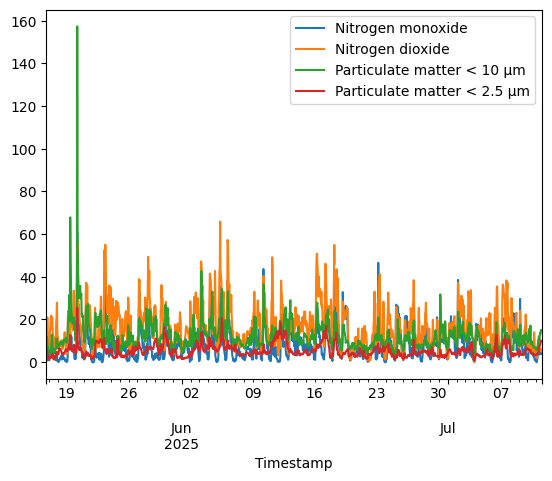

In [12]:
merged_df.plot(x = "Timestamp", y = ["Nitrogen monoxide",
                                    "Nitrogen dioxide", 
                                    "Particulate matter < 10 µm",
                                    "Particulate matter < 2.5 µm"])

In [13]:
data_air_pollution = show_air_pollution()

latt, long 60.1674881 24.9427473
data: {'Helsinki Kallio 2': {datetime.datetime(2025, 7, 11, 13, 0): {'Sulphur dioxide': {'value': 0.4, 'units': 'ug/m3'}, 'Nitrogen monoxide': {'value': 0.9, 'units': 'ug/m3'}, 'Nitrogen dioxide': {'value': 3.6, 'units': 'ug/m3'}, 'Ozone': {'value': 39.5, 'units': 'ug/m3'}, 'Odorous sulphur compounds': {'value': nan, 'units': 'ugS/m3'}, 'Carbon monoxide': {'value': nan, 'units': 'ug/m3'}, 'Particulate matter < 10 µm': {'value': 15.9, 'units': 'ug/m3'}, 'Particulate matter < 2.5 µm': {'value': 10.3, 'units': 'ug/m3'}, 'Air Quality Index': {'value': 2.0, 'units': 'index'}, 'musta hiili PM2.5': {'value': 0.17, 'units': 'ug/m3'}}}, 'Espoo Leppävaara Läkkisepänkuja': {datetime.datetime(2025, 7, 11, 13, 0): {'Sulphur dioxide': {'value': nan, 'units': 'ug/m3'}, 'Nitrogen monoxide': {'value': 1.3, 'units': 'ug/m3'}, 'Nitrogen dioxide': {'value': 4.0, 'units': 'ug/m3'}, 'Ozone': {'value': nan, 'units': 'ug/m3'}, 'Odorous sulphur compounds': {'value': nan, 'units

In [14]:
import folium
from folium import Popup
from geopy.geocoders import Nominatim

# Example data (replace with your actual data)

# Initialize a map centered on Helsinki
m = folium.Map(location=[60.1695, 24.9354], zoom_start=10)

# Add markers for each location
for location, info in data_air_pollution.items():
    coords = info['Lattitude'], info['Longitude']
    air_data = data_air_pollution
    
    # Create a popup with air quality information
    popup_content = f"<b>{location}</b><br>"

    #print(info)
    for pollutant, value in info.items():
        popup_content += f"{pollutant}: {value if value is not None else 'N/A'}<br>"
    
    popup = Popup(popup_content, max_width=300)
    
    # Add a marker to the map
    folium.Marker(location=coords, popup=popup).add_to(m)

# Display the map
m